In [43]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks


In [44]:
%run library_utils.ipynb

import os 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import transformers
assert transformers.__version__ >= '4.17.0'
from transformers import (
    AutoTokenizer, 
    AutoModel)
from tqdm import tqdm
from torch import Tensor
import torch.nn as nn

tqdm.pandas()

module = 'go-emotion-gru'
args = load_args(module)
init_seed(args.seed)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
device: cuda


### Tokenizer & Encoder

In [45]:
tokenizer = AutoTokenizer.from_pretrained(args.encoder_name)
encoder = AutoModel.from_pretrained(args.encoder_name)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
X_tk = tokenize_bert_inputs(
  ['hello my name is jeongwon', 'what are you?'], 
  tokenizer, 
  maxlen=args.sentence_max_len
)
len(X_tk['input_ids'][0])

62

In [47]:
%%time
dataset_path = os.path.join(args.output_dir, args.train_dataset_path)
assert os.path.exists(dataset_path)

train_dataset, val_dataset = generate_bert_dataset(
    dataset_path,     
    tokenizer, 
    emotions = args.emotions, 
    sentence_max_len = args.sentence_max_len, 
    split = args.validation_split_from_train
)

CPU times: user 11.4 s, sys: 407 ms, total: 11.9 s
Wall time: 7.66 s


In [48]:
class GoEmotionGRUClassifer(TransformerEncoderBase):
  def __init__(self, 
        encoder, 
        criterion=nn.BCEWithLogitsLoss(), 
        seq_len=82,
        rnn_hidden = 50,  
        rnn_num_layers = 1,
        bidirectional=True, 
        hiddens = None,
        dropout_p=0.1, 
        n_cls:int = 28
    ):
    config = {
        'seq_len': seq_len, 
        'rnn_hidden': rnn_hidden, 
        'rnn_num_layers': rnn_num_layers, 
        'bidirectional': bidirectional, 
        'hiddens':  [50] if hiddens is None else hiddens, 
        'dropout_p': dropout_p, 
        'n_cls': n_cls
    }
    super().__init__(encoder, criterion, config)

    # layers
    self.encoder = encoder
    self.gru = nn.GRU(
        input_size= self.encoder_dim, 
        hidden_size = rnn_hidden, 
        batch_first = True, 
        bidirectional = bidirectional
    )
    self.dropout = nn.Dropout(dropout_p)

    # full connected
    fcs = []
    in_feature = (int(bidirectional) + 1) * rnn_hidden
    for h in self.config['hiddens']:
      fcs.append(nn.Linear(in_feature, h))
      fcs.append(nn.ReLU())
      in_feature = h    
    
    # final layer 
    fcs.append(nn.Linear(in_feature, n_cls))
    self.fcs = nn.Sequential(*fcs)

  def forward(self, input_ids, attention_mask, y_true=None):
    encoder_output = super().forward(input_ids, attention_mask)
    contextual_emb = encoder_output['last_hidden_state']

    output, _ = self.gru(contextual_emb)
    output = output[:, -1, :]
    z = self.dropout(output) 
    logits = self.fcs(z)

    if not (y_true is None):
      loss = self.criterion(logits, y_true)
      return (loss, logits)

    return logits

In [49]:
def create_go_emotion_gru(args, encoder):
    return GoEmotionGRUClassifer(
        encoder, 
        seq_len=args.sentence_max_len,
        rnn_hidden=args.rnn_hidden, 
        rnn_num_layers = args.rnn_num_layers, 
        bidirectional=args.bidirectional, 
        hiddens = args.fc_hiddens, 
        dropout_p = args.dropout_p, 
        n_cls = len(args.emotions)
    )

model = create_go_emotion_gru(args, encoder)
model

GoEmotionGRUClassifer(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_

In [50]:
def proba_on_examples(texts, model):
    X_tk = tokenize_bert_inputs(
        texts, tokenizer, maxlen = args.sentence_max_len
    )
    X_tk['input_ids'] = Tensor(X_tk['input_ids']).type(torch.int32)
    X_tk['attention_mask'] = Tensor(X_tk['attention_mask']).type(torch.int32)
    proba = predict_proba_examples(X_tk, model)
    return proba

In [53]:
proba = proba_on_examples(['hello my name is jeongwon', 'nice to meet you!'], model)
proba_to_emotion(
    proba,
    args.classification_threshold, 
    args.emotions, 
)[0][:3]

[('admiration', 0.5127877), ('amusement', 0.4819842), ('anger', 0.47141832)]

In [54]:
proba = predict_proba_examples(val_dataset[:5], model)
y_true = val_dataset[:5]['y_true'].numpy()
compute_classification_metrics(y_true, proba, 0.1)

{'accuracy': 0.044444444444444446,
 'macro_f1': 0.0670194003527337,
 'macro_precision': 0.044444444444444446,
 'macro_recall': 0.14814814814814814,
 'micro_f1': 0.0851063829787234,
 'micro_precision': 0.044444444444444446,
 'micro_recall': 1.0,
 'weighted_f1': 0.49206349206349215,
 'weighted_precision': 0.3333333333333333,
 'weighted_recall': 1.0}

In [55]:
evaluate(
    model, 
    val_dataset, 
    batch_size = args.eval_batch_size, 
    threshold = args.classification_threshold, 
    device = args.device
)

{'accuracy': 0.04695688599307007,
 'loss': 0.6923284998571263,
 'macro_f1': 0.0882997470479051,
 'macro_precision': 0.04695688599307007,
 'macro_recall': 1.0,
 'micro_f1': 0.0897016613029486,
 'micro_precision': 0.04695688599307007,
 'micro_recall': 1.0,
 'trigger_rate': 1.0,
 'weighted_f1': 0.11955701106465137,
 'weighted_precision': 0.0643399480933103,
 'weighted_recall': 1.0}

In [57]:
model = create_go_emotion_gru(args, encoder)
_ = save_checkpoint(
    model, 
    args.output_dir, 
    model_name='testmodel',
    metadata=args
)

model_copy, _ = load_from_checkpoint(
    args.output_dir,
    model_name='testmodel',
    checkpoint_id='null-model', 
    model_cls=GoEmotionGRUClassifer
)

check_model_same(model, model_copy)

True

In [59]:
# clear_archive(args.output_dir, args.model_name)

True

In [60]:
model = create_go_emotion_gru(args, encoder)
model, metadata = train(
    model, 
    train_dataset, 
    val_dataset, 
    dict(args), 
    tokenizer, 
    epochs=args.train_epochs, 
    train_batch_size = args.train_batch_size, 
    val_batch_size = args.eval_batch_size, 
    save_steps = args.save_steps, 
    validation_steps= args.validation_steps, 
    archive_dir = args.output_dir, 
    model_name = args.model_name, 
    classification_threshold = args.classification_threshold, 
    learning_rate = args.learning_rate, 
    grad_clip_max = args.grad_clip_max, 
    weight_decay = args.weight_decay, 
    warmup_ratio = args.warmup_ratio, 
    logging_metrics= ['macro_f1', 'macro_precision', 'macro_recall'],
    continue_training=False,
    device = args.device
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


training epoch 0


evaluation:  99%|█████████▉| 1513/1526 [00:06<00:00, 226.82it/s]
                                                                
evaluation:  99%|█████████▉| 1508/1525 [00:06<00:00, 231.28it/s]
                                                                

evaluating at step 3000
val {'macro_precision': 0.04695688599307007, 'macro_recall': 1.0, 'macro_f1': 0.0882997470479051}
tr {'macro_precision': 0.047283168994761184, 'macro_recall': 1.0, 'macro_f1': 0.08884011407574152}
saving at step 3000


evaluation:  99%|█████████▉| 1516/1526 [00:06<00:00, 232.19it/s]
                                                                
Training:  98%|█████████▊| 6000/6101 [01:55<00:59,  1.68it/s]

evaluating at step 6000
val {'macro_precision': 0.02105244221018245, 'macro_recall': 0.4444444444444444, 'macro_f1': 0.039565597523527424}
tr {'macro_precision': 0.021029221538611535, 'macro_recall': 0.4444444444444444, 'macro_f1': 0.039509900895647994}
saving at step 6000


Training: 100%|██████████| 6101/6101 [01:57<00:00, 52.01it/s]


training epoch 1


evaluation: 100%|█████████▉| 1525/1526 [00:06<00:00, 226.37it/s]
                                                                
Training:  48%|████▊     | 2899/6101 [00:55<40:06,  1.33it/s]

evaluating at step 9000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 9000


evaluation:  99%|█████████▊| 1506/1526 [00:06<00:00, 220.47it/s]
                                                                
Training:  97%|█████████▋| 5899/6101 [01:53<02:21,  1.43it/s]

evaluating at step 12000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 12000


Training: 100%|██████████| 6101/6101 [01:56<00:00, 52.56it/s]


training epoch 2


evaluation:  99%|█████████▉| 1516/1526 [00:06<00:00, 231.33it/s]
                                                                
Training:  46%|████▌     | 2798/6101 [00:54<30:43,  1.79it/s]

evaluating at step 15000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 15000


evaluation: 100%|█████████▉| 1523/1526 [00:06<00:00, 227.13it/s]
                                                                
Training:  95%|█████████▌| 5798/6101 [01:51<02:53,  1.75it/s]

evaluating at step 18000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 18000


Training: 100%|██████████| 6101/6101 [01:55<00:00, 52.64it/s]


training epoch 3


evaluation:  99%|█████████▉| 1508/1526 [00:06<00:00, 224.86it/s]
                                                                
Training:  44%|████▍     | 2697/6101 [00:52<37:09,  1.53it/s]

evaluating at step 21000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 21000


evaluation: 100%|█████████▉| 1522/1526 [00:06<00:00, 228.91it/s]
                                                                
Training:  93%|█████████▎| 5697/6101 [01:49<03:47,  1.78it/s]

evaluating at step 24000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 24000


Training: 100%|██████████| 6101/6101 [01:55<00:00, 52.80it/s]


training epoch 4


evaluation:  99%|█████████▉| 1515/1526 [00:06<00:00, 226.17it/s]
                                                                
Training:  43%|████▎     | 2596/6101 [00:51<43:17,  1.35it/s]

evaluating at step 27000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 27000


evaluation: 100%|█████████▉| 1521/1526 [00:06<00:00, 221.11it/s]
                                                                
Training:  92%|█████████▏| 5596/6101 [01:48<05:01,  1.68it/s]

evaluating at step 30000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 30000


Training: 100%|██████████| 6101/6101 [01:55<00:00, 52.71it/s]


training epoch 5


evaluation: 100%|█████████▉| 1521/1526 [00:06<00:00, 220.27it/s]
                                                                
Training:  41%|████      | 2495/6101 [00:49<38:13,  1.57it/s]

evaluating at step 33000
val {'macro_precision': 0.05487009354321827, 'macro_recall': 0.03562885529147592, 'macro_f1': 0.04112253489727843}
tr {'macro_precision': 0.054805667902588735, 'macro_recall': 0.036674559640910015, 'macro_f1': 0.041891463560771794}
saving at step 33000


evaluation:  99%|█████████▊| 1506/1526 [00:06<00:00, 224.83it/s]
                                                                
evaluation:  99%|█████████▉| 1509/1525 [00:06<00:00, 225.26it/s]
                                                                

evaluating at step 36000
val {'macro_precision': 0.056339507890759526, 'macro_recall': 0.04123114518665456, 'macro_f1': 0.0473971594398967}
tr {'macro_precision': 0.05632226665666441, 'macro_recall': 0.04170094306826139, 'macro_f1': 0.047633233377158996}
saving at step 36000


Training: 100%|██████████| 6101/6101 [01:56<00:00, 52.58it/s]


training epoch 6


evaluation:  99%|█████████▉| 1511/1526 [00:06<00:00, 228.26it/s]
                                                                
Training:  39%|███▉      | 2394/6101 [00:48<42:46,  1.44it/s]

evaluating at step 39000
val {'macro_precision': 0.05565228550631844, 'macro_recall': 0.04168913005324158, 'macro_f1': 0.04740858382465079}
tr {'macro_precision': 0.0558798849630665, 'macro_recall': 0.042280745829762593, 'macro_f1': 0.04778973639211082}
saving at step 39000


evaluation: 100%|█████████▉| 1523/1526 [00:06<00:00, 228.30it/s]
                                                                
Training:  88%|████████▊ | 5394/6101 [01:45<08:53,  1.32it/s]

evaluating at step 42000
val {'macro_precision': 0.10785288139986474, 'macro_recall': 0.06291568303441261, 'macro_f1': 0.0723677763242285}
tr {'macro_precision': 0.10886177076308524, 'macro_recall': 0.06286593073492379, 'macro_f1': 0.07208086338047287}
saving at step 42000


Training: 100%|██████████| 6101/6101 [01:55<00:00, 52.71it/s]


training epoch 7


evaluation:  98%|█████████▊| 1503/1526 [00:06<00:00, 223.34it/s]
                                                                
Training:  38%|███▊      | 2293/6101 [00:46<34:12,  1.86it/s]

evaluating at step 45000
val {'macro_precision': 0.12445580144217551, 'macro_recall': 0.10432169186434105, 'macro_f1': 0.11339237713864722}
tr {'macro_precision': 0.1242937593468098, 'macro_recall': 0.10263267033396051, 'macro_f1': 0.11227721411901014}
saving at step 45000


evaluation: 100%|█████████▉| 1525/1526 [00:06<00:00, 225.85it/s]
                                                                
evaluation:  99%|█████████▉| 1506/1525 [00:06<00:00, 226.04it/s]
                                                                

evaluating at step 48000
val {'macro_precision': 0.12193065144732874, 'macro_recall': 0.11133049235127282, 'macro_f1': 0.11608624829618801}
tr {'macro_precision': 0.1588305373265786, 'macro_recall': 0.10984415286343312, 'macro_f1': 0.11529182369806754}
saving at step 48000


Training: 100%|██████████| 6101/6101 [01:56<00:00, 52.50it/s]


training epoch 8


evaluation:  99%|█████████▉| 1510/1526 [00:06<00:00, 217.58it/s]
                                                                
Training:  36%|███▌      | 2192/6101 [00:45<49:50,  1.31it/s]

evaluating at step 51000
val {'macro_precision': 0.16941092663837468, 'macro_recall': 0.11431995456345767, 'macro_f1': 0.1273580587198324}
tr {'macro_precision': 0.17385089042674273, 'macro_recall': 0.11392490487648756, 'macro_f1': 0.1282752608729473}
saving at step 51000


evaluation: 100%|█████████▉| 1523/1526 [00:06<00:00, 224.52it/s]
                                                                
Training:  85%|████████▌ | 5192/6101 [01:43<09:39,  1.57it/s]

evaluating at step 54000
val {'macro_precision': 0.20404811135294842, 'macro_recall': 0.1270021195186176, 'macro_f1': 0.13655345018316897}
tr {'macro_precision': 0.23141083409258542, 'macro_recall': 0.12604143095233208, 'macro_f1': 0.13629693432011755}
saving at step 54000


Training: 100%|██████████| 6101/6101 [01:56<00:00, 52.20it/s]


training epoch 9


evaluation:  99%|█████████▊| 1505/1526 [00:06<00:00, 218.04it/s]
                                                                
Training:  34%|███▍      | 2091/6101 [00:44<47:41,  1.40it/s]

evaluating at step 57000
val {'macro_precision': 0.22158423948255937, 'macro_recall': 0.13688978965495174, 'macro_f1': 0.15211177883317561}
tr {'macro_precision': 0.2934873787825213, 'macro_recall': 0.1402458621983614, 'macro_f1': 0.1566749270514018}
saving at step 57000


evaluation:  99%|█████████▉| 1517/1526 [00:06<00:00, 216.49it/s]
                                                                
evaluation: 100%|█████████▉| 1520/1525 [00:06<00:00, 227.64it/s]
                                                                

evaluating at step 60000
val {'macro_precision': 0.293915127381492, 'macro_recall': 0.13809829306409035, 'macro_f1': 0.15505350852724767}
tr {'macro_precision': 0.26559034987921987, 'macro_recall': 0.13919012678115683, 'macro_f1': 0.1570479486162272}
saving at step 60000


Training: 100%|██████████| 6101/6101 [01:57<00:00, 52.02it/s]


training epoch 10


evaluation: 100%|█████████▉| 1519/1526 [00:06<00:00, 222.43it/s]
                                                                
Training:  33%|███▎      | 1990/6101 [00:43<38:43,  1.77it/s]

evaluating at step 63000
val {'macro_precision': 0.3287369982460462, 'macro_recall': 0.1497798157856327, 'macro_f1': 0.17173525504463105}
tr {'macro_precision': 0.2963408141147028, 'macro_recall': 0.15383812471899863, 'macro_f1': 0.17675375510303135}
saving at step 63000


evaluation:  99%|█████████▉| 1515/1526 [00:06<00:00, 201.96it/s]
                                                                
Training:  82%|████████▏ | 4990/6101 [01:41<13:47,  1.34it/s]

evaluating at step 66000
val {'macro_precision': 0.3406926684580387, 'macro_recall': 0.1673757644795724, 'macro_f1': 0.18991425700608322}
tr {'macro_precision': 0.306406745555482, 'macro_recall': 0.1727466497571679, 'macro_f1': 0.19587852636266304}
saving at step 66000


Training: 100%|██████████| 6101/6101 [01:57<00:00, 51.78it/s]


training epoch 11


evaluation:  98%|█████████▊| 1503/1526 [00:06<00:00, 222.70it/s]
                                                                
Training:  31%|███       | 1889/6101 [00:41<43:35,  1.61it/s]

evaluating at step 69000
val {'macro_precision': 0.37928156750952485, 'macro_recall': 0.18061561304649593, 'macro_f1': 0.20828172653512617}
tr {'macro_precision': 0.4160113691615254, 'macro_recall': 0.18978204723358907, 'macro_f1': 0.2198578098423435}
saving at step 69000


evaluation:  99%|█████████▉| 1517/1526 [00:06<00:00, 217.89it/s]
                                                                
Training:  80%|████████  | 4889/6101 [01:40<12:54,  1.57it/s]

evaluating at step 72000
val {'macro_precision': 0.392181434158974, 'macro_recall': 0.17891064536359427, 'macro_f1': 0.21182671017606203}
tr {'macro_precision': 0.4230286654354572, 'macro_recall': 0.1877489295804707, 'macro_f1': 0.22277532083374715}
saving at step 72000


Training: 100%|██████████| 6101/6101 [01:58<00:00, 51.56it/s]


training epoch 12


evaluation:  99%|█████████▉| 1515/1526 [00:06<00:00, 214.55it/s]
                                                                
evaluation:  99%|█████████▉| 1509/1525 [00:06<00:00, 214.69it/s]
                                                                

evaluating at step 75000
val {'macro_precision': 0.40304437510037516, 'macro_recall': 0.1985663880948392, 'macro_f1': 0.23448778617598695}
tr {'macro_precision': 0.44850244293001135, 'macro_recall': 0.21384944956142982, 'macro_f1': 0.25277608368320975}
saving at step 75000


evaluation: 100%|█████████▉| 1520/1526 [00:06<00:00, 229.41it/s]
                                                                
evaluation:  99%|█████████▊| 1503/1525 [00:06<00:00, 222.58it/s]
                                                                

evaluating at step 78000
val {'macro_precision': 0.40937855361417047, 'macro_recall': 0.20234855381409927, 'macro_f1': 0.2405854461814911}
tr {'macro_precision': 0.4389558031756923, 'macro_recall': 0.21685316241735947, 'macro_f1': 0.258261335512164}
saving at step 78000


Training: 100%|██████████| 6101/6101 [01:58<00:00, 51.69it/s]


training epoch 13


evaluation:  99%|█████████▊| 1505/1526 [00:06<00:00, 225.98it/s]
                                                                
evaluation:  99%|█████████▉| 1516/1525 [00:06<00:00, 219.71it/s]
                                                                

evaluating at step 81000
val {'macro_precision': 0.4390161192800099, 'macro_recall': 0.2214668063550915, 'macro_f1': 0.261315446767076}
tr {'macro_precision': 0.5013971015648868, 'macro_recall': 0.24320182968131873, 'macro_f1': 0.2886821271178683}
saving at step 81000


evaluation: 100%|█████████▉| 1522/1526 [00:06<00:00, 221.02it/s]
                                                                
evaluation:  99%|█████████▉| 1509/1525 [00:06<00:00, 222.41it/s]
                                                                

evaluating at step 84000
val {'macro_precision': 0.42188586019928964, 'macro_recall': 0.22631530129027347, 'macro_f1': 0.265972953047192}
tr {'macro_precision': 0.4879790190007324, 'macro_recall': 0.2498935163422813, 'macro_f1': 0.2947752124896976}
saving at step 84000


Training: 100%|██████████| 6101/6101 [01:58<00:00, 51.47it/s]


training epoch 14


evaluation:  99%|█████████▉| 1511/1526 [00:07<00:00, 214.08it/s]
                                                                
Training:  26%|██▌       | 1586/6101 [00:38<53:27,  1.41it/s]

evaluating at step 87000
val {'macro_precision': 0.42519307748219587, 'macro_recall': 0.22720560628249795, 'macro_f1': 0.2673777279230198}
tr {'macro_precision': 0.5027009084041991, 'macro_recall': 0.25931638820925995, 'macro_f1': 0.3081474315230122}
saving at step 87000


evaluation:  99%|█████████▉| 1514/1526 [00:07<00:00, 211.00it/s]
                                                                
evaluation: 100%|█████████▉| 1522/1525 [00:07<00:00, 222.39it/s]
                                                                

evaluating at step 90000
val {'macro_precision': 0.4213343280983973, 'macro_recall': 0.22878230979405836, 'macro_f1': 0.27299603166047626}
tr {'macro_precision': 0.4946622906990918, 'macro_recall': 0.25871302834963156, 'macro_f1': 0.3103253834449579}
saving at step 90000


Training: 100%|██████████| 6101/6101 [01:59<00:00, 51.15it/s]


training epoch 15


evaluation: 100%|█████████▉| 1519/1526 [00:06<00:00, 223.20it/s]
                                                                
evaluation:  99%|█████████▉| 1509/1525 [00:07<00:00, 223.02it/s]
                                                                

evaluating at step 93000
val {'macro_precision': 0.4161658115005882, 'macro_recall': 0.23468070662033153, 'macro_f1': 0.28020667251651965}
tr {'macro_precision': 0.4993293127537082, 'macro_recall': 0.2773186023331992, 'macro_f1': 0.33338725070771746}
saving at step 93000


evaluation:  99%|█████████▉| 1517/1526 [00:07<00:00, 205.03it/s]
                                                                
evaluation:  99%|█████████▉| 1506/1525 [00:07<00:00, 196.64it/s]
                                                                

evaluating at step 96000
val {'macro_precision': 0.3947813876972725, 'macro_recall': 0.25345015472720994, 'macro_f1': 0.28674192085670824}
tr {'macro_precision': 0.4762890955288563, 'macro_recall': 0.2936328879663294, 'macro_f1': 0.33604484501249743}
saving at step 96000


Training: 100%|██████████| 6101/6101 [01:59<00:00, 51.04it/s]


training epoch 16


evaluation:  99%|█████████▉| 1517/1526 [00:06<00:00, 217.07it/s]
                                                                
evaluation:  99%|█████████▉| 1516/1525 [00:06<00:00, 200.80it/s]
                                                                

evaluating at step 99000
val {'macro_precision': 0.39848441285153335, 'macro_recall': 0.24494385937959862, 'macro_f1': 0.286240004722475}
tr {'macro_precision': 0.5134991281874589, 'macro_recall': 0.2964061917778913, 'macro_f1': 0.34941881736782704}
saving at step 99000


evaluation:  99%|█████████▉| 1510/1526 [00:06<00:00, 222.66it/s]
                                                                
evaluation:  98%|█████████▊| 1502/1525 [00:07<00:00, 212.11it/s]
                                                                

evaluating at step 102000
val {'macro_precision': 0.4515779116919984, 'macro_recall': 0.24810482665368025, 'macro_f1': 0.29054287189835687}
tr {'macro_precision': 0.5495432700731927, 'macro_recall': 0.29302939838117364, 'macro_f1': 0.3472716648365013}
saving at step 102000


Training: 100%|██████████| 6101/6101 [01:59<00:00, 51.16it/s]


training epoch 17


evaluation: 100%|█████████▉| 1523/1526 [00:08<00:00, 210.03it/s]
                                                                
Training:  21%|██        | 1283/6101 [00:35<1:13:23,  1.09it/s]

evaluating at step 105000
val {'macro_precision': 0.45674513573878206, 'macro_recall': 0.2571719157209364, 'macro_f1': 0.2981009834672774}
tr {'macro_precision': 0.5636566919371074, 'macro_recall': 0.31707683060848457, 'macro_f1': 0.37138989812521933}
saving at step 105000


evaluation:  99%|█████████▉| 1511/1526 [00:06<00:00, 224.87it/s]
                                                                
Training:  70%|███████   | 4283/6101 [01:34<19:07,  1.58it/s]

evaluating at step 108000
val {'macro_precision': 0.4820011297566246, 'macro_recall': 0.2534299989028984, 'macro_f1': 0.2972113719997361}
tr {'macro_precision': 0.5518832357743875, 'macro_recall': 0.3072356895957693, 'macro_f1': 0.3636637906855178}
saving at step 108000


Training: 100%|██████████| 6101/6101 [02:01<00:00, 50.32it/s]


training epoch 18


evaluation:  99%|█████████▊| 1506/1526 [00:06<00:00, 219.50it/s]
                                                                
evaluation: 100%|█████████▉| 1519/1525 [00:06<00:00, 216.96it/s]
                                                                

evaluating at step 111000
val {'macro_precision': 0.4418808110241573, 'macro_recall': 0.2530728298792994, 'macro_f1': 0.29485606593305075}
tr {'macro_precision': 0.5761077721143543, 'macro_recall': 0.3203089959955481, 'macro_f1': 0.377899031950107}
saving at step 111000


evaluation:  99%|█████████▉| 1514/1526 [00:07<00:00, 216.44it/s]
                                                                
Training:  69%|██████▊   | 4182/6101 [01:31<24:58,  1.28it/s]

evaluating at step 114000
val {'macro_precision': 0.4698564701644728, 'macro_recall': 0.25979069909413005, 'macro_f1': 0.3017627174347563}
tr {'macro_precision': 0.5594556551380968, 'macro_recall': 0.32358116092356887, 'macro_f1': 0.3793018508064332}
saving at step 114000


Training: 100%|██████████| 6101/6101 [01:59<00:00, 50.93it/s]


training epoch 19


evaluation: 100%|█████████▉| 1519/1526 [00:07<00:00, 208.57it/s]
                                                                
Training:  18%|█▊        | 1081/6101 [00:30<1:07:11,  1.25it/s]

evaluating at step 117000
val {'macro_precision': 0.4317059323858002, 'macro_recall': 0.2669739261778571, 'macro_f1': 0.3099384326603333}
tr {'macro_precision': 0.5676901449566122, 'macro_recall': 0.3460539438432541, 'macro_f1': 0.4062076152698509}
saving at step 117000


evaluation:  99%|█████████▊| 1505/1526 [00:06<00:00, 219.44it/s]
                                                                
Training:  67%|██████▋   | 4081/6101 [01:29<29:23,  1.15it/s]

evaluating at step 120000
val {'macro_precision': 0.43515653601513454, 'macro_recall': 0.27676067742338506, 'macro_f1': 0.31353849245125787}
tr {'macro_precision': 0.5606113326600111, 'macro_recall': 0.3493699691827669, 'macro_f1': 0.4007901823310404}
saving at step 120000


Training: 100%|██████████| 6101/6101 [01:59<00:00, 50.93it/s]


In [62]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

df = get_attrs_from_checkpoints_meta(args.output_dir, args.model_name, [
    'tr_metrics.loss', 
    'tr_metrics.trigger_rate',
    'val_metrics.loss', 
    'val_metrics.trigger_rate', 
    'val_metrics.accuracy', 
    'val_metrics.macro_f1',
    'val_metrics.micro_f1'
])
df.head(3)

,tr_metrics.loss,tr_metrics.trigger_rate,val_metrics.loss,val_metrics.trigger_rate,val_metrics.accuracy,val_metrics.macro_f1,val_metrics.micro_f1,checkpoint_id
0,0.666192,0.999997,0.666167,1.000000,0.046957,0.088300,0.089702,3000
1,0.513049,0.444443,0.512836,0.444451,0.550697,0.039566,0.085682,6000
2,0.260806,0.000000,0.260196,0.000000,0.953043,0.000000,0.000000,9000


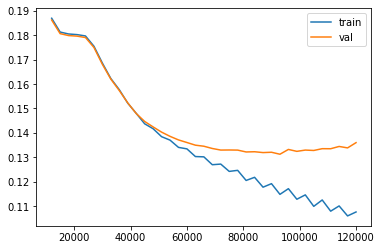

In [65]:
plt.plot(df['checkpoint_id'][3:], df['tr_metrics.loss'][3:], label='train')
plt.plot(df['checkpoint_id'][3:], df['val_metrics.loss'][3:], label='val')
plt.legend()

In [66]:
proba = predict_proba(
    model, 
    val_dataset, 
    batch_size = args.eval_batch_size, 
    device = args.device
)
y_true = val_dataset[:]['y_true'].numpy()

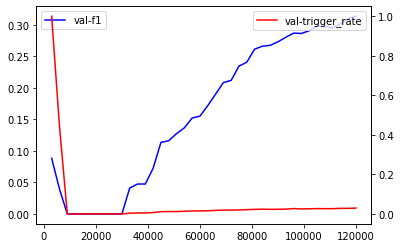

In [68]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df['checkpoint_id'], 
         df['val_metrics.macro_f1'], 
         label='val-f1', c='blue')
ax2.plot(df['checkpoint_id'], 
         df['val_metrics.trigger_rate'], 
         label='val-trigger_rate', c='red')

ax1.legend()
ax2.legend()

In [67]:
roc_auc_score(y_true, proba, average='macro')

0.8416928227846378

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


for i, emt in enumerate(args.emotions):
    fpr, tpr, _ = roc_curve(y_true[:, i], proba[:, i])
    plt.plot(fpr, tpr)
    plt.title(emt)
    plt.show()


In [ ]:
proba_to_emotion(
    proba_on_examples([
        'fuck cloud', 
        'yeet'
    ], model), 
    0.4, 
    args.emotions)